## Trasnfer learning of a sequence to sequence transformer

In [2]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=256, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(model_dim, 1)

    def forward(self, x):
        # x shape: [batch, time, 1]
        x = self.input_proj(x)                     # [batch, time, model_dim]
        x = self.positional_encoding(x)           # Add position info
        x = self.transformer_encoder(x)           # [batch, time, model_dim]
        return self.output_proj(x)                # [batch, time, 1]


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [3]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class AutoregressiveTimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=2, model_dim=256, num_heads=4, num_layers=2, dropout=0.1, max_len=1000):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim, max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(model_dim, 1)

    def forward(self, h, f):
        """
        h: [batch, seq_len, h_dim]
        f: [batch, seq_len, 1]    (previous targets)
        Predict f(t+1) for each t using [h(0:t), f(0:t)]
        """
        x = torch.cat([h, f], dim=-1)  # [batch, seq_len, h_dim + 1]
        x = self.input_proj(x)
        x = self.positional_encoding(x)

        # Causal mask to prevent using future info
        seq_len = x.size(1)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)

        x = self.transformer_encoder(x, mask=causal_mask)
        return self.output_proj(x)  # [batch, seq_len, 1]
    

def autoregressive_forecast(model, h_seq, f_start, horizon):
    """
    h_seq: [1, total_steps, h_dim]
    f_start: [1, 1] initial f value
    """
    model.eval()
    preds = []
    f_seq = [f_start]

    for t in range(horizon):
        f_input = torch.cat(f_seq, dim=1)  # [1, t+1, 1]
        h_input = h_seq[:, :t+1, :]        # [1, t+1, h_dim]

        with torch.no_grad():
            pred = model(h_input, f_input)  # [1, t+1, 1]
            next_val = pred[:, -1:, :]      # only last prediction

        f_seq.append(next_val)
        preds.append(next_val)

    return torch.cat(preds, dim=1)  # [1, horizon, 1]

In [3]:
model=AutoregressiveTimeSeriesTransformer()
print(model)

AutoregressiveTimeSeriesTransformer(
  (input_proj): Linear(in_features=2, out_features=256, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_proj): Linear(in_features=256, out_features=1, bias=True)
)


In [10]:
import torch
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,   # <--- Enable bidirectional
            dropout=dropout if num_layers > 1 else 0.0
        )
        # Because BiLSTM concatenates forward and backward outputs, output dim = hidden_size * 2
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # x: [batch, seq_len, input_size]
        out, _ = self.bilstm(x)  # out: [batch, seq_len, hidden_size*2]
        out = self.fc(out)       # map to output size at each timestep
        return out

New training step

In [ ]:


import torch
import random
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def autoregressive_train_epoch(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio=1.0, alpha=1e-3, bptt_steps=1):
    model.train()
    total_loss = 0
    preds_all, targets_all = [], []

    for h_batch, f_batch in dataloader:
        h_batch = h_batch.to(device)
        f_batch = f_batch.to(device)

        B, T, _ = f_batch.shape
        optimizer.zero_grad()

        f_input = f_batch[:, :1, :]
        prev_pred = None

        preds = []

        for t in range(1, T):
            h_input = h_batch[:, :t, :]

            use_teacher = random.random() < teacher_forcing_ratio
            f_in = f_batch[:, :t, :] if use_teacher else f_input

            out = model(h_input)
            pred_t = out[:, -1:, :]
            target_t = f_batch[:, t:t+1, :]

            preds.append(pred_t.detach().cpu())

            main_loss = criterion(pred_t, target_t)
            smooth_loss = torch.mean((pred_t - prev_pred) ** 2) if prev_pred is not None else torch.tensor(0.0, device=device)
            step_loss = main_loss + alpha * smooth_loss

            step_loss.backward()

            # Gradient clipping per step
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            prev_pred = pred_t.detach()  # Detach to prevent graph growth

            if not use_teacher:
                f_input = torch.cat([f_input, pred_t.detach()], dim=1)

            total_loss += step_loss.item()

        with torch.no_grad():
            full_pred = torch.cat(preds, dim=1)
            preds_all.append(full_pred.cpu())
            targets_all.append(f_batch[:, 1:, :].cpu())

        torch.cuda.empty_cache()

    preds_all = torch.cat(preds_all).squeeze(-1).numpy()
    targets_all = torch.cat(targets_all).squeeze(-1).numpy()

    mse = mean_squared_error(targets_all, preds_all)
    mae = mean_absolute_error(targets_all, preds_all)
    rmse = np.sqrt(mse)

    return total_loss / ((T - 1) * len(dataloader)), mae, rmse

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import torch

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    preds_all, targets_all = [], []

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)

        preds_all.append(outputs.detach().cpu())
        targets_all.append(targets.detach().cpu())

        torch.cuda.empty_cache()

    avg_loss = total_loss / len(dataloader.dataset)
    preds_all = torch.cat(preds_all).numpy().squeeze(-1)
    targets_all = torch.cat(targets_all).numpy().squeeze(-1)

    mae = mean_absolute_error(targets_all, preds_all)
    mse = mean_squared_error(targets_all, preds_all)
    rmse = np.sqrt(mse)

    return avg_loss, mae, rmse

#### Dataloading

In [62]:
import numpy as np
import matplotlib.pyplot as plt

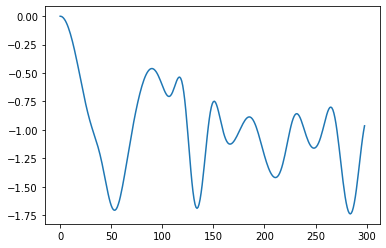

(10000, 300, 1) (10000, 300, 1)


In [63]:
data=np.load('data/dataset_h_eff/new_analysis_xxzx_model/dataset_2025-03-03_16-43.npz')

h_eff=data['h_eff'][:10000,:300,]
h=data['h'][:10000,:300]

plt.plot(h_eff[100,1:,0])
plt.show()
print(h_eff.shape,h.shape)

In [64]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, h_array, f_array):
        self.h = torch.from_numpy(h_array).float()  # shape: [B, T, 1]
        self.f = torch.from_numpy(f_array).float()  # shape: [B, T, 1]

    def __len__(self):
        return len(self.h)

    def __getitem__(self, idx):
        return self.h[idx], self.f[idx]

In [60]:
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
# Assume h_array and f_array are numpy arrays of shape [batch, time, 1]
dataset = TimeSeriesDataset(h, h_eff)

# Define split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTMModel(input_size=1, hidden_size=64, output_size=1, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()



epochs = 50
for epoch in range(epochs):
    tf_ratio = max(0.5, 1.0 - epoch / epochs)  # Linear decay
    loss, mae, rmse = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1} | Loss: {loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

Epoch 1 | Loss: 0.0458 | MAE: 0.1143 | RMSE: 0.2140
Epoch 2 | Loss: 0.0107 | MAE: 0.0613 | RMSE: 0.1033
Epoch 3 | Loss: 0.0095 | MAE: 0.0567 | RMSE: 0.0976
Epoch 4 | Loss: 0.0088 | MAE: 0.0548 | RMSE: 0.0940
Epoch 5 | Loss: 0.0070 | MAE: 0.0501 | RMSE: 0.0837
Epoch 6 | Loss: 0.0044 | MAE: 0.0405 | RMSE: 0.0665
Epoch 7 | Loss: 0.0035 | MAE: 0.0357 | RMSE: 0.0593
Epoch 8 | Loss: 0.0031 | MAE: 0.0330 | RMSE: 0.0553
Epoch 9 | Loss: 0.0028 | MAE: 0.0310 | RMSE: 0.0525
Epoch 10 | Loss: 0.0026 | MAE: 0.0298 | RMSE: 0.0506
Epoch 11 | Loss: 0.0024 | MAE: 0.0282 | RMSE: 0.0485
Epoch 12 | Loss: 0.0023 | MAE: 0.0280 | RMSE: 0.0475
Epoch 13 | Loss: 0.0021 | MAE: 0.0267 | RMSE: 0.0453
Epoch 14 | Loss: 0.0019 | MAE: 0.0257 | RMSE: 0.0441
Epoch 15 | Loss: 0.0020 | MAE: 0.0262 | RMSE: 0.0446
Epoch 16 | Loss: 0.0017 | MAE: 0.0239 | RMSE: 0.0411
Epoch 17 | Loss: 0.0017 | MAE: 0.0243 | RMSE: 0.0416
Epoch 18 | Loss: 0.0017 | MAE: 0.0243 | RMSE: 0.0414
Epoch 19 | Loss: 0.0016 | MAE: 0.0238 | RMSE: 0.0402
Ep

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesTransformer(input_dim=1, model_dim=128, num_heads=2, num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    tf_ratio = max(0.5, 1.0 - epoch / epochs)  # Linear decay
    loss, mae, rmse = autoregressive_train_epoch(model, train_loader, optimizer, criterion, device, teacher_forcing_ratio=tf_ratio)
    print(f"Epoch {epoch+1} | Loss: {loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

KeyboardInterrupt: 

Prediction autoregressive

In [32]:
h_eff_prediction=autoregressive_forecast(model=model.to(device='cpu',dtype=torch.double),h_seq=torch.tensor(h[:10,:,:]),f_start=torch.tensor(h_eff[:10,1:2]),horizon=1000)

torch.Size([10, 1000, 1])


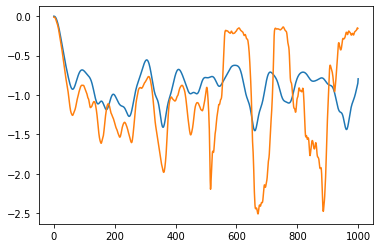

In [35]:
print(h_eff_prediction.shape)

plt.plot(h_eff[3])
plt.plot(h_eff_prediction[3])
plt.show()

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 600

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    for h_batch,f_batch in train_loader:
        h_batch, f_batch = h_batch.to(device), f_batch.to(device)
        seq_len = 700
        x = h_batch[:, :seq_len]
        y = f_batch[:, :seq_len]
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # for h_batch, f_batch in train_loader:
    #     h_batch, f_batch = h_batch.to(device), f_batch.to(device)
        


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for h_batch, f_batch in val_loader:
            h_batch, f_batch = h_batch.to(device), f_batch.to(device)
            output = model(h_batch)
            loss = criterion(output, f_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/len(train_loader):.6f}, "
          f"Val Loss: {val_loss/len(val_loader):.6f}")

Epoch 1/600, Train Loss: 0.606787, Val Loss: 0.132854
Epoch 2/600, Train Loss: 0.121915, Val Loss: 0.028359
Epoch 3/600, Train Loss: 0.023512, Val Loss: 0.020984
Epoch 4/600, Train Loss: 0.014203, Val Loss: 0.022025
Epoch 5/600, Train Loss: 0.011584, Val Loss: 0.018830
Epoch 6/600, Train Loss: 0.010098, Val Loss: 0.018595
Epoch 7/600, Train Loss: 0.009761, Val Loss: 0.021266
Epoch 8/600, Train Loss: 0.009002, Val Loss: 0.016779
Epoch 9/600, Train Loss: 0.008213, Val Loss: 0.016759
Epoch 10/600, Train Loss: 0.008064, Val Loss: 0.017524
Epoch 11/600, Train Loss: 0.007515, Val Loss: 0.017958
Epoch 12/600, Train Loss: 0.007784, Val Loss: 0.017118
Epoch 13/600, Train Loss: 0.007198, Val Loss: 0.016420


KeyboardInterrupt: 

#### Test

In [65]:
data=np.load('data/dataset_h_eff/new_analysis_xxzx_model/dataset_2025-03-03_16-43.npz')

h_eff=data['h_eff'][:100]
h=data['h'][:100]

h_tensor=torch.from_numpy(h)



In [66]:
model.eval()
model=model.to(device='cpu').to(dtype=torch.float)
h_eff_prediction=model(h_tensor.to(dtype=torch.float))

print(h_eff_prediction.shape,h_eff_prediction)

torch.Size([100, 1001, 1]) tensor([[[-2.1346e-03],
         [-3.5739e-03],
         [-3.9642e-03],
         ...,
         [-6.8029e-01],
         [-6.9332e-01],
         [-7.0692e-01]],

        [[-3.0884e-04],
         [-1.9298e-03],
         [-1.8683e-03],
         ...,
         [-1.1176e+00],
         [-1.0912e+00],
         [-1.0678e+00]],

        [[-2.9203e-03],
         [-4.3769e-03],
         [-5.0776e-03],
         ...,
         [-9.3701e-01],
         [-9.1625e-01],
         [-9.0119e-01]],

        ...,

        [[-1.5085e-03],
         [-2.9750e-03],
         [-3.1615e-03],
         ...,
         [-6.7333e-01],
         [-6.7049e-01],
         [-6.7426e-01]],

        [[-2.6350e-04],
         [-1.8948e-03],
         [-1.8342e-03],
         ...,
         [-9.8940e-01],
         [-9.7704e-01],
         [-9.6269e-01]],

        [[-1.2708e-03],
         [-2.7588e-03],
         [-2.8821e-03],
         ...,
         [-1.3212e+00],
         [-1.2784e+00],
         [-1.2547e+00]]],

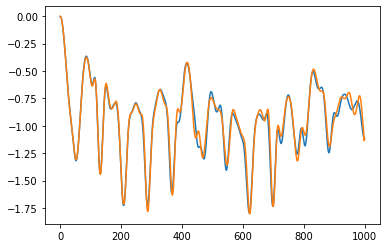

In [92]:
import matplotlib.pyplot as plt
idx=np.random.randint(0,100)
plt.plot(h_eff_prediction[idx,1:,0].detach().numpy())
plt.plot(h_eff[idx,1:,0])

plt.show()

#### Autoregressive case

In [79]:
import torch
import torch.nn as nn

class AutoRegressiveTransformer(nn.Module):
    def __init__(self, input_dim=2, model_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.predictor = nn.Linear(model_dim, 1)

    def forward(self, h_f_seq):
        # h_f_seq: [batch, time, 2]  (concatenated [h(t), f(t)] input)
        x = self.input_proj(h_f_seq)              # [batch, time, model_dim]
        x = self.positional_encoding(x)           # Add position info
        x = self.transformer(x)                   # [batch, time, model_dim]
        return self.predictor(x)                  # [batch, time, 1]

In [84]:
from tqdm import trange

model=AutoRegressiveTransformer()

num_epochs=100

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_loss=0.
for epoch in trange(num_epochs):
    for h_seq, f_seq in train_loader:
        h_seq=h_seq[:,:500]
        f_seq=f_seq[:,:500]
        input_seq = torch.cat([h_seq, f_seq], dim=-1)  # [batch, T, 2]
        target = f_seq

        output = model(input_seq)
        loss = criterion(output[:, :-1], target[:, 1:])  # predict f(t+1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        print(loss.item())

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/len(train_loader):.6f}, ")
    
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

0.7113147377967834
0.23613341152668
0.36817610263824463
0.43692463636398315
0.28544995188713074
0.159218892455101
0.14247064292430878
0.16818547248840332
0.23459307849407196
0.1761067509651184
0.12480521947145462
0.0908532366156578
0.08052540570497513
0.08641450107097626


  0%|          | 0/100 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def autoregressive_forecast(model, h_seq, f_start, steps):
    """
    h_seq: [1, T+steps, 1]  (known exogenous values)
    f_start: [1, T, 1]      (initial known target values)
    """
    preds = []
    f_seq = f_start.clone()

    for t in range(steps):
        inp = torch.cat([h_seq[:, :f_seq.shape[1]], f_seq], dim=-1)
        out = model(inp)
        next_f = out[:, -1:]   # last time step
        f_seq = torch.cat([f_seq, next_f], dim=1)
        preds.append(next_f)

    return torch.cat(preds, dim=1)  # [1, steps, 1]